# 01. House Price Prediction Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats

In [ ]:
# import the dataset

from google.colab import files
uploaded = files.upload()

Saving House data.csv to House data (3).csv


In [ ]:
df = pd.read_csv('House data.csv')

# Pre-process the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [ ]:
# Drop meaningless columns
df.drop(['date', 'street', 'statezip', 'country'], axis=1, inplace=True)


In [ ]:
# Print columns to check for 'Year_built'
print(df.columns)




Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'city'],
      dtype='object')


In [ ]:

# Convert 'yr_built' to 'Age'
df.insert(0, "Age", df["yr_built"].max()+1 - df["yr_built"])
df.drop('yr_built', axis=1, inplace=True)


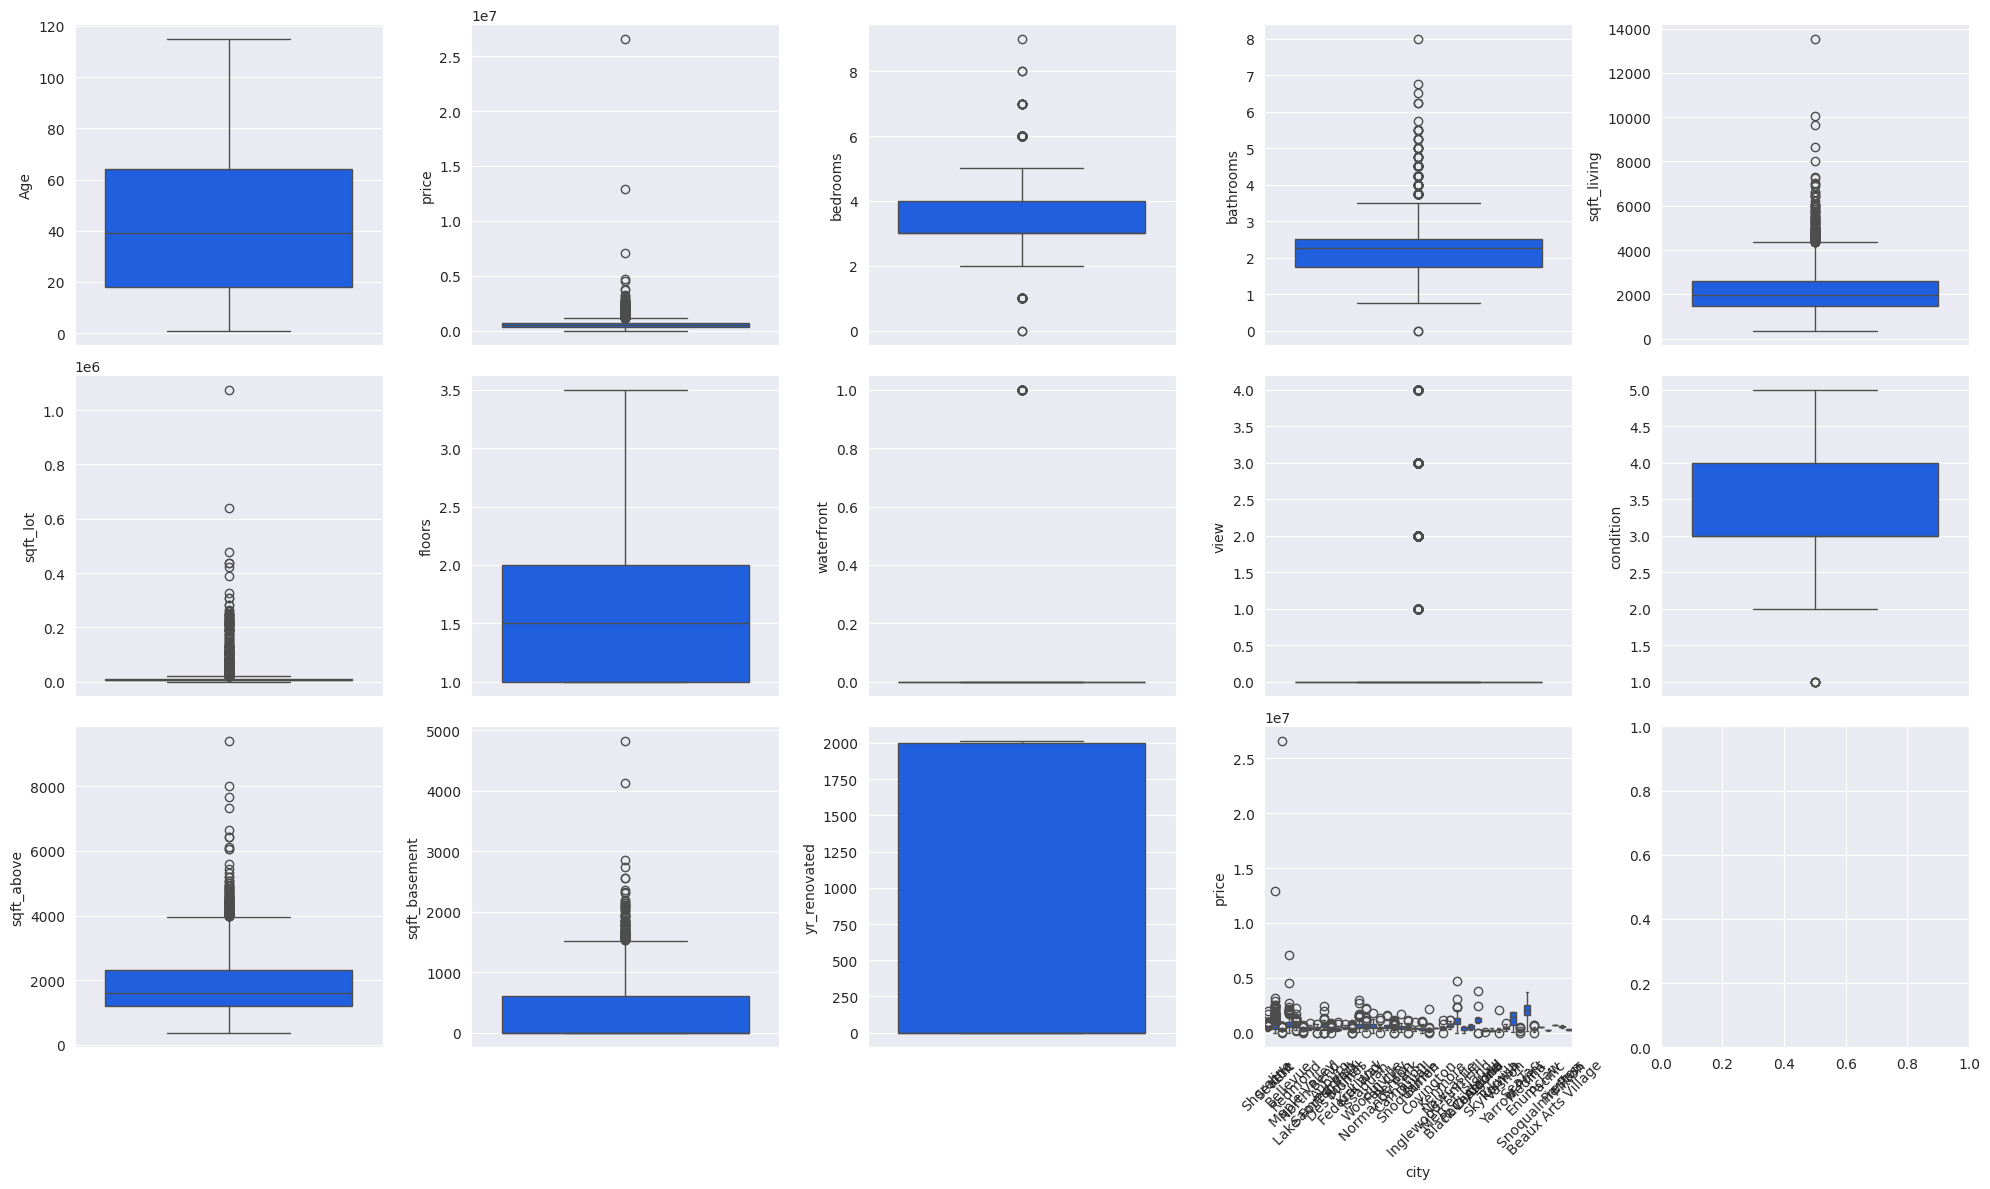

In [ ]:
# Data Visualization and Outlier Detection
sns.set_style('darkgrid')
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

OrderedCols = np.concatenate([df.select_dtypes(exclude='object').columns.values,
                             df.select_dtypes(include='object').columns.values])

fig, ax = plt.subplots(3, 5, figsize=(20,12), dpi=100)

for i,col in enumerate(OrderedCols):
    x = i//5
    y = i%5
    if df[col].dtype != 'object':
        sns.boxplot(data=df, y=col, ax=ax[x,y])
    else:
        sns.boxplot(data=df, x=col, y='price', ax=ax[x,y])
    ax[x,y].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
##### find the outliers using the InterQuartile Range rule######
outliers_indexes = []
target = 'price'

# Categorical outliers
for col in df.select_dtypes(include='object').columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())

# Numerical outliers
for col in df.select_dtypes(exclude='object').columns:
    if col != target:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())

outliers_indexes = list(set(outliers_indexes))
print(f'{len(outliers_indexes)} outliers identified:\n{outliers_indexes[:10]}...')

1173 outliers identified:
[2048, 1, 7, 8, 2057, 2056, 11, 4108, 2061, 14]...


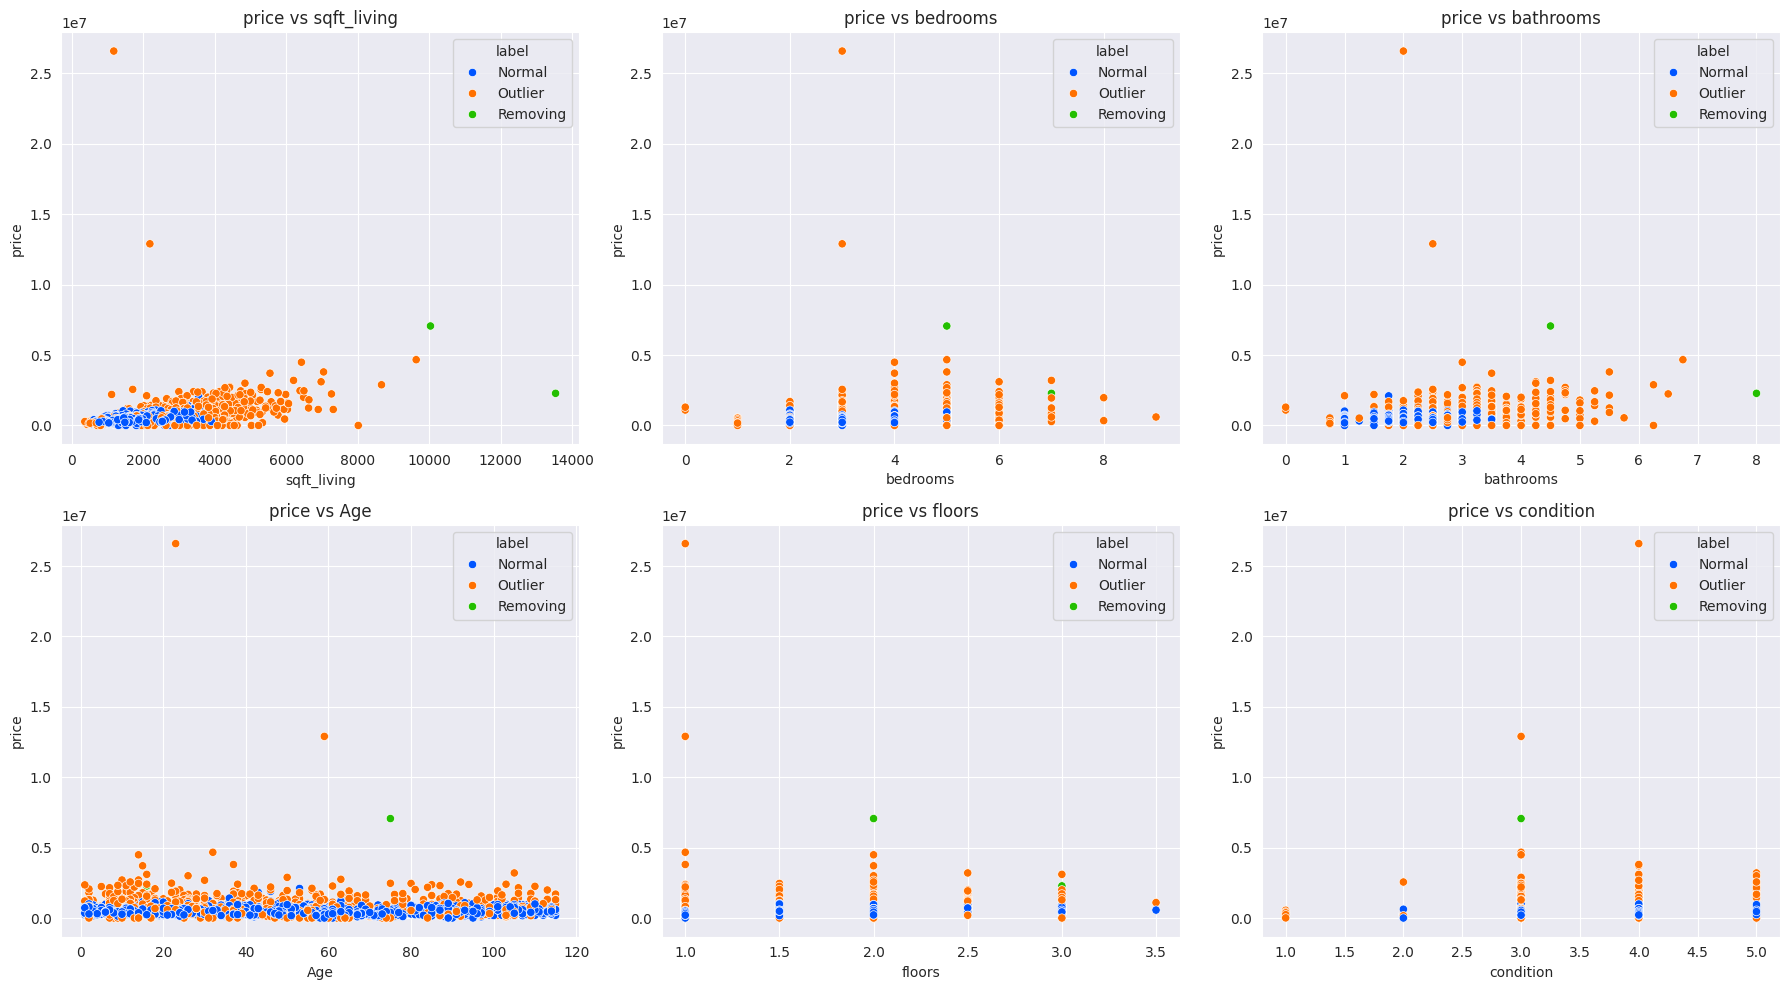

In [ ]:
########dig even more and find the perfect outliers.##########

df1 = df.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes,'label'] = 'Outlier'

# Remove extreme cases
removing_indexes = []
removing_indexes.extend(df1[df1['sqft_living'] > 10000].index)  # Houses > 10,000 sqft
df1.loc[removing_indexes,'label'] = 'Removing'

# Plot top 6 features vs price
features = ['sqft_living', 'bedrooms', 'bathrooms', 'Age', 'floors', 'condition']
fig, ax = plt.subplots(2, 3, figsize=(18,10), dpi=100)

for i, col in enumerate(features):
    x, y = i//3, i%3
    sns.scatterplot(data=df1, x=col, y=target, hue='label', ax=ax[x,y])
    ax[x,y].set_title(f'price vs {col}')

plt.tight_layout()
plt.show()

In [ ]:
# perfect outliers
removing_indexes = list(set(removing_indexes))
removing_indexes

[122, 2286]

In [ ]:
#check if there's any null data in dataset.
df.isnull().sum()

Age              0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_renovated     0
city             0
dtype: int64

In [ ]:
# remove the identified outliers and reset the index of the dataframe.

df1 = df.copy()
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)
print(f'Final dataset shape: {df1.shape}')

Final dataset shape: (4598, 14)


# **Analyze the Dataset**

In [ ]:
# identify the numerical and categorical fields in our dataset

NumCols = ['Age', 'price', 'sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'sqft_above', 'sqft_basement']
CatCols = ['city','waterfront', 'view', 'condition']

### price vs Numerical Features Bivariate Analysis

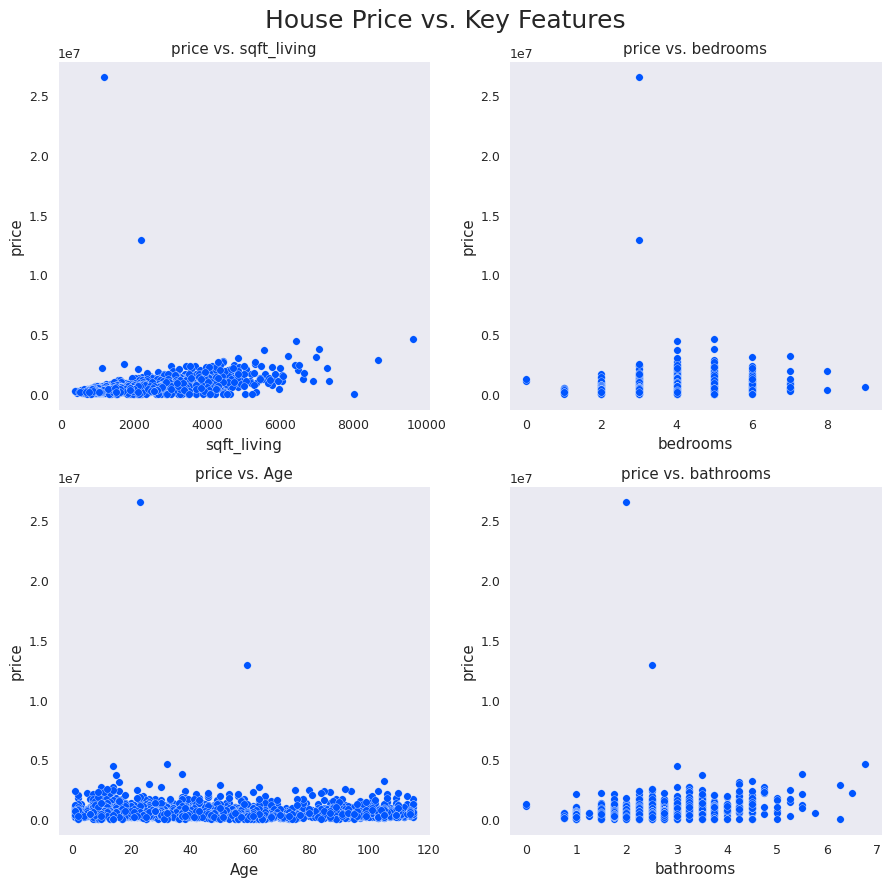

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10), dpi=90)
num_features = ['sqft_living', 'bedrooms', 'Age', 'bathrooms']
target = 'price'
c = '#0055ff'

for i in range(len(num_features)):
    row = i//2
    col = i%2
    ax[row,col].scatter(df1[num_features[i]], df1[target], color=c, edgecolors='w', linewidths=0.25)
    ax[row,col].set_title('{} vs. {}'.format(target, num_features[i]), size=12)
    ax[row,col].set_xlabel(num_features[i], size=12)
    ax[row,col].set_ylabel(target, size=12)
    ax[row,col].grid()

plt.suptitle('House Price vs. Key Features', size=20)
plt.tight_layout()
plt.show()

##  Price vs Categorical Features Bivariate Analysis

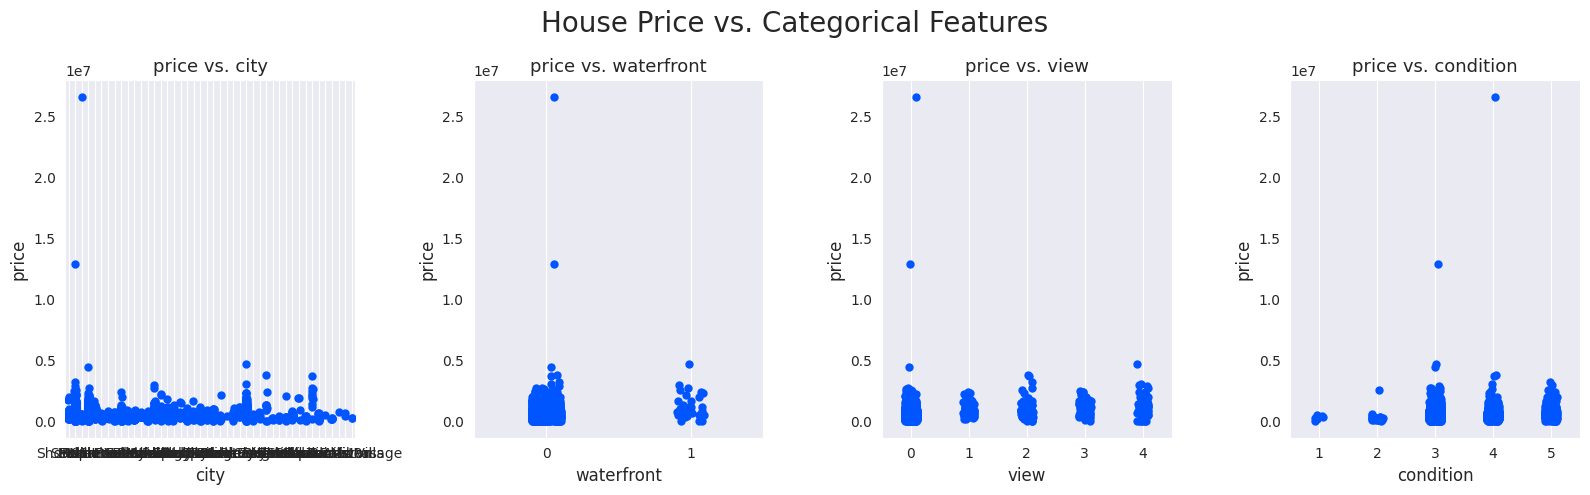

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,5), dpi=100)
cat_features = ['city','waterfront', 'view', 'condition']
target = 'price'
c = '#0055ff'

for i in range(len(cat_features)):
    sns.stripplot(ax=axes[i], x=cat_features[i], y=target, data=df1, size=6, color=c)
    axes[i].set_title('{} vs. {}'.format(target, cat_features[i]), size=13)
    axes[i].set_xlabel(cat_features[i], size=12)
    axes[i].set_ylabel(target, size=12)
    axes[i].grid()

plt.suptitle('House Price vs. Categorical Features', size=20)
plt.tight_layout()
plt.show()

# **Categorical Variables Encoding**

In [ ]:
CatCols = ['city','waterfront', 'view', 'condition']

df1 = pd.get_dummies(df1, columns=CatCols, drop_first=True)
df1.head(5)

Age      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   60   313000.0       3.0       1.50         1340      7912     1.5   
1   94  2384000.0       5.0       2.50         3650      9050     2.0   
2   49   342000.0       3.0       2.00         1930     11947     1.0   
3   52   420000.0       3.0       2.25         2000      8030     1.0   
4   39   550000.0       4.0       2.50         1940     10500     1.0   

   sqft_above  sqft_basement  yr_renovated  ...  city_Yarrow Point  \
0        1340              0          2005  ...              False   
1        3370            280             0  ...              False   
2        1930              0             0  ...              False   
3        1000           1000             0  ...              False   
4        1140            800          1992  ...              False   

   waterfront_1  view_1  view_2  view_3  view_4  condition_2  condition_3  \
0         False   False   False   False   False        False         True   
1         False   False   False   False    True        False        False   
2         False   False   False   False   False        False        False   
3         False   False   False   False   False        False        False   
4         False   False   False   False   False        False        False   

   condition_4  condition_5  
0        False        False  
1        False         True  
2         True        False  
3         True        False  
4         True        False  

[5 rows x 62 columns]

# Correlation **Analysis**

In [ ]:
target = 'price'
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 10), dpi=100)
ax = sns.heatmap(df1[NumCols].corr(), annot=True, cmap=cmap)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# **Build the Model**

In [ ]:
X = df1.drop(['price'], axis=1)
y = df1['price']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
y_test_actual = y_test

## Normalize the dataset

In [ ]:
# normalize dataset using StandardScaler.
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train the model

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
#find the intercept and co-efficient for each column in  training dataset.

pd.DataFrame(data = np.append(linear_reg.intercept_ , linear_reg.coef_), index = ['Intercept']+[col+" Coef." for col in X.columns], columns=['Value']).sort_values('Value', ascending=False)

Value
Intercept               551819.675534
city_Seattle Coef.      134819.274428
sqft_living Coef.       109971.148503
sqft_above Coef.        107759.449416
city_Bellevue Coef.      84690.318683
...                               ...
city_Auburn Coef.         -447.572402
sqft_lot Coef.            -881.616628
city_Enumclaw Coef.      -1094.734112
city_Federal Way Coef.   -1706.228543
bedrooms Coef.          -36186.037120

[62 rows x 1 columns]

## How to evaluate the model

In [ ]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)

    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE' ,'R2-Score'], columns=[model_name])

model_evaluation(linear_reg, X_test_scaled, y_test, 'Linear Reg.')

Linear Reg.
MAE       1.404764e+05
MSE       5.463559e+11
RMSE      7.391589e+05
R2-Score  9.159863e-02

## Evaluate the model using K-fold Cross-Validation

In [ ]:
linear_reg_cv = LinearRegression()
scaler = StandardScaler()
pipeline = make_pipeline(StandardScaler(),  LinearRegression())

kf = KFold(n_splits=6, shuffle=True, random_state=0)
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

MAE_mean = (-result['test_neg_mean_absolute_error']).mean()
MAE_std = (-result['test_neg_mean_absolute_error']).std()
MSE_mean = (-result['test_neg_mean_squared_error']).mean()
MSE_std = (-result['test_neg_mean_squared_error']).std()
RMSE_mean = (-result['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result['test_neg_root_mean_squared_error']).std()
R2_Score_mean = result['test_r2'].mean()
R2_Score_std = result['test_r2'].std()

pd.DataFrame({'Mean': [MAE_mean,MSE_mean,RMSE_mean,R2_Score_mean], 'Std': [MAE_std,MSE_std,RMSE_std,R2_Score_std]},
             index=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

Mean           Std
MAE       1.374729e+05  1.328912e+04
MSE       2.344993e+11  3.326026e+11
RMSE      3.926792e+05  2.833767e+05
R2-Score  4.590416e-01  2.221589e-01

# **Results Visualization**

In [ ]:
#create a dataframe with the actual and predicted values.
y_test_pred = linear_reg.predict(X_test_scaled)
df_comp = pd.DataFrame({'Actual':y_test_actual, 'Predicted':y_test_pred})

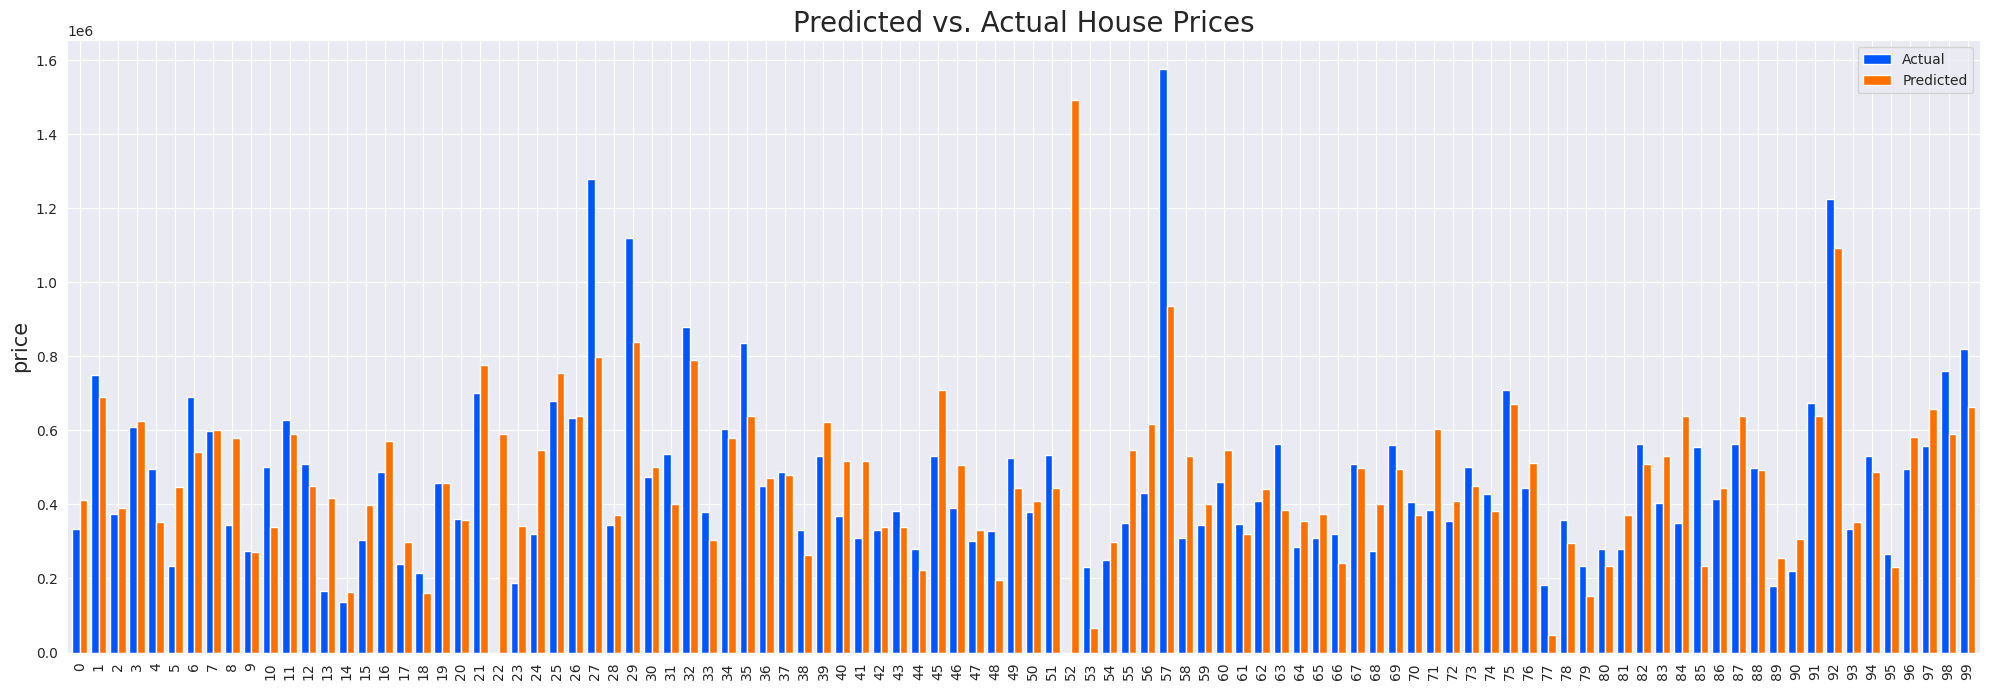

In [ ]:
def compare_plot(df_comp):
    df_comp.reset_index(inplace=True)
    if len(df_comp) > 100:
        df_comp = df_comp.head(100)
    df_comp.plot(y=['Actual','Predicted'], kind='bar', figsize=(20,7), width=0.8)
    plt.title('Predicted vs. Actual House Prices', fontsize=20)
    plt.ylabel('price', fontsize=15)
    plt.tight_layout()
    plt.show()

compare_plot(df_comp)